# EVC for p-alpha scattering, addressing non-local potential and Coulomb potential. 
Here we do tests of eigenvector continuation (EC) for proton-alpha scattering in the $S_{1/2}$ and $P_{3/2}$ channels based on a non-local potential from [Rev. Mod. Phys. 57, 923 (1985)](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.57.923). The codes are the same as those in the NN scattering notebook (`EVC_NN.ipynb`). The inputs are different here.  

Figures S3 and 5 from [arXiv:2007.03635](https://arxiv.org/abs/2007.03635), "Efficient emulators for scattering using eigenvector continuation" by R.J. Furnstahl, P.J. Millican, and Xilin Zhang are generated here.

#### Table of contents

1. [A code for testing the covex hull of  basis points](#convex_hull_code)
1. [Set up the ouput directory](#output_dir)
1. [Code for generating results](#main_code)
1. [Proton-alpha scattering](#Main_calculations)
  1. [Set the global parameters and define the potential](#global_para_setup) 
  1. [S-wave: test EC using a sample of test points in a 2-dim parameter space](#test_EC_2dim)
  1. [P-wave (3/2): test EC using a sample of test points in a 2-dim parameter space](#test_EC_2dim_p3/2)
1. [Collect the results and make plots for both channels (Figs. S3 and 5)](#plots)     
  


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.integrate import simps
from scipy.optimize import linprog
import matplotlib.pyplot as plt

from pyDOE import lhs   # https://pythonhosted.org/pyDOE/
import pickle

# local imports
from Constants import * 
from two_body_pot import two_body_pot,  rmat_ini
from evc_two_body import EigenvectorContinuationScattering


## A code for testing the convex hull of  basis points. <a id="convex_hull_code"></a>
This checks within a parameter space whether a point is inside or outside the convex hull of a given set of basis points.

In [2]:
def in_hull(points, x):
    '''points are basis points that define the convex hull,
    while x is the point to be tested.
    '''
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

## Set up the ouput directory <a id="output_dir"></a>
Set up a dictionary to save the calculation results. The pkl file will be saved in the output directory.

In [3]:
outdir='./Notebook_output/p_alpha/'
res_dict={}

## Code for generating results <a id="main_code"></a>
As in the NN notebook (`EVC_NN.ipynb`):

In [4]:
def collect_results(outdir='./', channel='1S0', nuggetsize=1.e-10,  num_basis_list=range(3,10), 
                     basis_potpara_array_list=np.array([]), test_potpara_list=np.array([]), 
                    local_pot_func= lambda r : 0, nonlocal_pot_func=lambda rvec:0 ):
    test_pc_list=[ ]
    num_test, dim_para=np.shape(test_potpara_list)
    for i, test_potpara  in enumerate(test_potpara_list):
        if i%10==0: print(f'setting up test potential class list: {i, num_test }')
        test_local_pot_func= lambda r : local_pot_func(r, test_potpara)
        test_nonlocal_pot_func= lambda rvec : nonlocal_pot_func(rvec, test_potpara)
        test_pc = two_body_pot(pot_func=test_nonlocal_pot_func, local_pot_func= test_local_pot_func,
                       mu=mu, hbar=hbarc, E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)   
        test_pc_list.append(test_pc)
    test_pc_list=np.array(test_pc_list)

    for i, num_basis in enumerate(num_basis_list):
        # num_basis is the number of potential-basis
        print('looping over basis array: ' + f'{num_basis}')
        output_file_prefix=outdir +channel + '_para-dim-' + f'{dim_para}' \
        + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_test}' + '_'
        # output-file prefix, which is used as key for the result dictionary. 
        basis_potpara_array = basis_potpara_array_list[i]
        testinouthaull= np.apply_along_axis(lambda x : in_hull(basis_potpara_array, x), 1, test_potpara_list) 
        # testinouthuall: a boolen list of whether the test point is insdie or outside the convex haul of basis points
        local_pot_func_array = [(lambda V0var:
                             (lambda r : local_pot_func(r, V0var ) ) )(V0val) for V0val in basis_potpara_array ]
        nonlocal_pot_func_array = [(lambda V0var:
                             (lambda rvec : nonlocal_pot_func(rvec, V0var ) ) )(V0val) for V0val in basis_potpara_array ]
        pc_array = [two_body_pot( pot_func=nonlocal_pot_func_array[ii], local_pot_func= local_pot_func, mu=mu, hbar=hbarc, 
                         E_mesh=E_pts, r_c=r_c, r_max=r_max, r_in_mesh_pts=nr, r_out_mesh_pts=nr,
                        angL=angL, z_t=z_t, z_p= z_p)  for ii, local_pot_func  in  enumerate(local_pot_func_array)]       
        tau_var_mesh_list= [] 
        ere_var_mesh_list=[]  
        c_vec_mesh_list=[] 
        lag_mesh_list=[]
        delta_tilde_U_condition_mesh_list=[]
        test_pc_list_E_mesh_list=[]
        test_pc_list_delta_mesh_list=[]
        test_pc_list_tau_mesh_list=[]
        test_pc_list_ere_mesh_list=[]
        for j, test_potpara  in  enumerate(test_potpara_list):
            test_local_pot_func= lambda r : local_pot_func(r, test_potpara)
            test_nonlocal_pot_func= lambda rvec : nonlocal_pot_func(rvec, test_potpara)
            my_evc = EigenvectorContinuationScattering(pc_array) 
            tau_var_mesh, ere_var_mesh, c_vec_mesh, lag_mesh, delta_tilde_U_condition_mesh = \
            my_evc.find_EVC_scattering(new_pot_func=test_nonlocal_pot_func, new_local_pot_func=test_local_pot_func, 
                                       pinv=False, nugget=True, cond=nuggetsize)
            tau_var_mesh_list.append(tau_var_mesh ) 
            ere_var_mesh_list.append(ere_var_mesh)
            c_vec_mesh_list.append(c_vec_mesh) 
            lag_mesh_list.append(lag_mesh)
            delta_tilde_U_condition_mesh_list.append(delta_tilde_U_condition_mesh)
            test_pc_list_E_mesh_list.append(test_pc_list[j].E_mesh)
            test_pc_list_delta_mesh_list.append(test_pc_list[j].delta_mesh)
            test_pc_list_tau_mesh_list.append(test_pc_list[j].tau_mesh)
            test_pc_list_ere_mesh_list.append(test_pc_list[j].ere_mesh)
        res_dict[output_file_prefix] = {"test_potpara_list":test_potpara_list, "basis_potpara_array":basis_potpara_array, 
                                    "test_pc_list_E_mesh_list": np.array(test_pc_list_E_mesh_list), 
                                    "test_pc_list_delta_mesh_list": np.array(test_pc_list_delta_mesh_list), 
                                    "test_pc_list_tau_mesh_list": np.array(test_pc_list_tau_mesh_list), 
                                    "test_pc_list_ere_mesh_list": np.array(test_pc_list_ere_mesh_list),
                                    "testinouthaull": testinouthaull, 
                                    "tau_var_mesh_list": np.array(tau_var_mesh_list), 
                                    "ere_var_mesh_list": np.array(ere_var_mesh_list),  
                                    "c_vec_mesh_list ": np.array(c_vec_mesh_list) , "lag_mesh_list" : np.array(lag_mesh_list), 
                                    "delta_tilde_U_condition_mesh_list" : np.array(delta_tilde_U_condition_mesh_list) }   
    return test_pc_list

## Proton-alpha scattering <a id="Main_calculations"></a>

### Set the global parameters and define the potential  <a id="global_para_setup"></a>
Note: for faster evaluation, choose `nr=50`, `r_c=12`. Explanations of variables can be found in the NN notebook (`EVC_NN.ipynb`). 

In [5]:
mu = 4*M_N/5; hbar = hbarc; r_c = 12.; r_max = 20; z_p = 1; z_t = 2; 
nr = 50;
E_pts = np.linspace(0.01, 30, 100)

In [6]:
def f(r, angL, beta):
    return r**angL * np.exp(-beta*r)

def nonlocal_pot_func_p_alpha(rvec, angL, V0, beta):
    r = rvec[0]
    rp = rvec[1]
    return V0 * f(r, angL, beta ) * f(rp, angL, beta)


In [7]:
V_shalf = -6.5 * hbarc**2 / 2 / mu; beta_shalf = 0.8; 
V_p3half = -11.25 * hbarc**2 / 2 / mu; beta_p3half = 1.25;
V_shalf,  V_p3half

(-168.28237761597495, -291.2579612584182)

### S-wave: test EC using a sample of test points in a 2-dim parameter space  <a id="test_EC_2dim"></a>
Vary both the potential strength and width

In [8]:
angL=0
channel='Shalf'

In [9]:
deltaV= 100 # MeV, the plus and minus range of potential-strength's variation
deltawidth_relative=0.5
num_full=200 # number of test-potential points
dim_para=2 # dim of the parameter space 
nuggetsize=1.e-8
np.random.seed(8209)

test_potpara_list= np.apply_along_axis(lambda v : np.array( [ V_shalf+ (v[0] - 0.5)*2*deltaV  , 
                                                              beta_shalf*( 1 + (v[1] - 0.5)/0.5*deltawidth_relative) ] ) , 
                            1,  np.random.rand(num_full, dim_para))  
num_basis_list= np.arange(3,10)
np.random.seed(754)
basis_potpara_array_list= [np.apply_along_axis(lambda v : np.array( [ V_shalf+ (v[0] - 0.5)*2*deltaV  , 
                                                              beta_shalf*( 1 + (v[1] - 0.5)/0.5*deltawidth_relative) ] ) , 
                            1, lhs(dim_para,num_basis))  for num_basis in num_basis_list]
local_pot_func= lambda r, potpara_vec : 0 
nonlocal_pot_func= lambda rvec, potpara_vec: nonlocal_pot_func_p_alpha(rvec, angL, V0=potpara_vec[0], beta=potpara_vec[1]) 


In [10]:
test_pc_list_Shalf = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                     basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                    local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 200)
setting up test potential class list: (10, 200)
setting up test potential class list: (20, 200)
setting up test potential class list: (30, 200)
setting up test potential class list: (40, 200)
setting up test potential class list: (50, 200)
setting up test potential class list: (60, 200)
setting up test potential class list: (70, 200)
setting up test potential class list: (80, 200)
setting up test potential class list: (90, 200)
setting up test potential class list: (100, 200)
setting up test potential class list: (110, 200)
setting up test potential class list: (120, 200)
setting up test potential class list: (130, 200)
setting up test potential class list: (140, 200)
setting up test potential class list: (150, 200)
setting up test potential class list: (160, 200)
setting up test potential class list: (170, 200)
setting up test potential class list: (180, 200)
setting up test potential class list: (190, 200)
looping over basis array: 3
loo

In [11]:
### save the results to a file
with open(outdir + 'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

### P-wave (3/2): test EC using a sample of test points in a 2-dim parameter space  <a id="test_EC_2dim_p3/2"></a>
Vary both potential strength and width

In [12]:
angL=1
channel='P3half'

In [13]:
deltaV = 100 # MeV, the plus and minus range of potential-strength's variation
deltawidth_relative = 0.5
num_full = 200 # number of test-potential points
dim_para = 2   # dim of the parameter space 
nuggetsize = 1.e-8
np.random.seed(82349)

test_potpara_list = np.apply_along_axis(lambda v : np.array( [ V_p3half+ (v[0] - 0.5)*2*deltaV  , 
                                                              beta_p3half*( 1 + (v[1] - 0.5)/0.5*deltawidth_relative)] ) , 
                            1,  np.random.rand(num_full, dim_para))  
num_basis_list = np.arange(3,10)
np.random.seed(65324)
basis_potpara_array_list = [np.apply_along_axis(lambda v : np.array( [ V_p3half+ (v[0] - 0.5)*2*deltaV  , 
                                                              beta_p3half*( 1 + (v[1] - 0.5)/0.5*deltawidth_relative) ] ) , 
                            1, lhs(dim_para,num_basis))  for num_basis in num_basis_list]
local_pot_func = lambda r, potpara_vec : 0 
nonlocal_pot_func = lambda rvec, potpara_vec: nonlocal_pot_func_p_alpha(rvec, angL, V0=potpara_vec[0], beta=potpara_vec[1]) 

In [14]:
test_pc_list_P3half = collect_results(outdir=outdir, channel=channel, nuggetsize=nuggetsize, num_basis_list=num_basis_list, 
                      basis_potpara_array_list=basis_potpara_array_list, test_potpara_list=test_potpara_list, 
                      local_pot_func= local_pot_func, nonlocal_pot_func=nonlocal_pot_func) 

setting up test potential class list: (0, 200)
setting up test potential class list: (10, 200)
setting up test potential class list: (20, 200)
setting up test potential class list: (30, 200)
setting up test potential class list: (40, 200)
setting up test potential class list: (50, 200)
setting up test potential class list: (60, 200)
setting up test potential class list: (70, 200)
setting up test potential class list: (80, 200)
setting up test potential class list: (90, 200)
setting up test potential class list: (100, 200)
setting up test potential class list: (110, 200)
setting up test potential class list: (120, 200)
setting up test potential class list: (130, 200)
setting up test potential class list: (140, 200)
setting up test potential class list: (150, 200)
setting up test potential class list: (160, 200)
setting up test potential class list: (170, 200)
setting up test potential class list: (180, 200)
setting up test potential class list: (190, 200)
looping over basis array: 3
loo

In [15]:
### CONTINUE to save the results to a file
with open(outdir+'res_dict.pkl', 'wb') as output:
    pickle.dump(res_dict, output, pickle.HIGHEST_PROTOCOL)

## Collect the results and make plots for both channels <a id="plots"></a>

In [16]:
with open(outdir+'res_dict.pkl', 'rb') as output:
    res_dict=pickle.load(output)

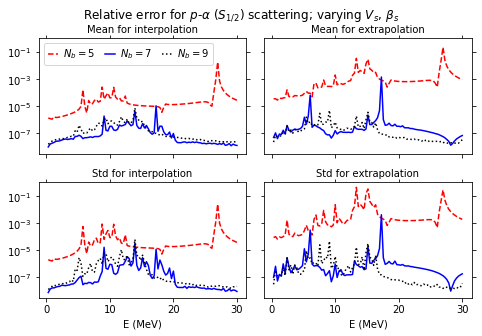

In [19]:
# for shalf
channel , dim_para,  num_full = 'Shalf', 2, 200 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for '+r'$p$-$\alpha$ ($S_{1/2}$)'+' scattering; varying '+r'$V_{s}$, $\beta_{s}$' , x=0.5, y= 1.02,  fontsize=12)

ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [5, 7, 9] 
for i, num_basis  in enumerate([5,7,9]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_tau_mesh_list, testinouthaull, tau_var_mesh_list  = \
            map(res_dict[output_file_prefix].get, ['test_pc_list_tau_mesh_list', 'testinouthaull', 'tau_var_mesh_list'] )   
    tau_mesh_list_1 = test_pc_list_tau_mesh_list[testinouthaull]
    tau_mesh_list_2 = test_pc_list_tau_mesh_list[np.logical_not(testinouthaull)]
    tau_var_mesh_list_1=tau_var_mesh_list[testinouthaull]
    tau_var_mesh_list_2=tau_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts[1:], np.mean( np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_1[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_1) ]) , axis=0 )[1:], label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts[1:], np.mean( np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_2[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_2) ]) , axis=0 )[1:], label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts[1:], np.std(np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_1[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_1) ]) , axis=0 )[1:],  label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts[1:], np.std(np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_2[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_2) ]) , axis=0 )[1:],  label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'Shalf_'+'interpolation_vs_extrapolation_rel_error_tau.pdf', bbox_inches='tight')  
    

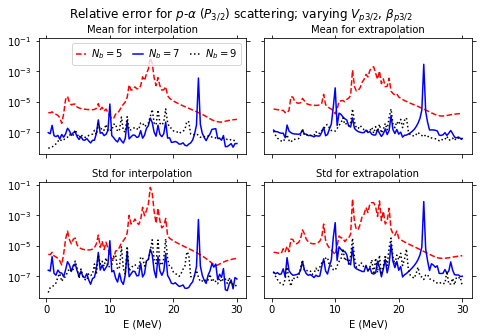

In [20]:
# for P3half
channel , dim_para,  num_full = 'P3half', 2, 200 
color_list= ['red', 'blue', 'black']  
linestyle_list= ['--', '-', ':']
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3.4*2, 3.4*2*2/3), sharex=True, sharey=True) 
fig.suptitle('Relative error for '+r'$p$-$\alpha$ ($P_{3/2}$)'+' scattering; varying '+r'$V_{p3/2}$, $\beta_{p3/2}$' , 
             x=0.5, y= 1.02,  fontsize=12)

ax[0,0].set_yscale('log')
ax[0,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,0].set_title('Mean for interpolation', fontsize= 10)
ax[0,1].set_yscale('log')
ax[0,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[0,1].set_title('Mean for extrapolation', fontsize= 10)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('E (MeV)', fontsize=10)
ax[1,0].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,0].set_title('Std for interpolation', fontsize= 10)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('E (MeV)', fontsize=10)
ax[1,1].tick_params(bottom=True, top=True, left=True, right=True)
ax[1,1].set_title('Std for extrapolation', fontsize= 10)
########### with num_basis = [5, 7, 9] 
for i, num_basis  in enumerate([5,7,9]) :  
    output_file_prefix=outdir + channel + '_para-dim-' + f'{dim_para}' \
    + '_basis-' + f'{num_basis}'+'_full-sample-' + f'{num_full}' + '_'
    test_pc_list_tau_mesh_list, testinouthaull, tau_var_mesh_list  = \
            map(res_dict[output_file_prefix].get, ['test_pc_list_tau_mesh_list', 'testinouthaull', 'tau_var_mesh_list'] )   
    tau_mesh_list_1 = test_pc_list_tau_mesh_list[testinouthaull]
    tau_mesh_list_2 = test_pc_list_tau_mesh_list[np.logical_not(testinouthaull)]
    tau_var_mesh_list_1=tau_var_mesh_list[testinouthaull]
    tau_var_mesh_list_2=tau_var_mesh_list[np.logical_not(testinouthaull)]    
    ax[0,0].plot(E_pts[1:], np.mean( np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_1[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_1) ]) , axis=0 )[1:], label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[0,1].plot(E_pts[1:], np.mean( np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_2[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_2) ]) , axis=0 )[1:], label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[1,0].plot(E_pts[1:], np.std(np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_1[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_1) ]) , axis=0 )[1:],  label = r"$N_b=$"+f'{num_basis}',
                color=color_list[i], linestyle=linestyle_list[i])
    ax[1,1].plot(E_pts[1:], np.std(np.array( [ np.absolute(tau_mesh/tau_var_mesh_list_2[i]-1) 
                    for i, tau_mesh in enumerate(tau_mesh_list_2) ]) , axis=0 )[1:],  label = r"$N_b=$"+f'{num_basis}' ,
                color=color_list[i], linestyle=linestyle_list[i])
ax[0,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[0,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,0].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
#ax[1,1].legend(loc='best', fontsize=10, ncol=3 , columnspacing=1, handlelength=1, handletextpad=0.5) 
fig.tight_layout()
plt.savefig(outdir+'P3half_'+'interpolation_vs_extrapolation_rel_error_tau.pdf', bbox_inches='tight')  
    